# Problem set 2

In class and in Forsyth and Ponce, chapter 7 we discussed window-based approaches to estimating dense stereo correspondence. In this problem set you will implement such approaches and evaluate it on some standard stereo pairs.

Anywhere you see `...` you need to fill in with your own choices.

In [131]:
import os
import time

import cv2
import matplotlib.pyplot as plt
import numpy as np

plt.set_cmap('gray')

<Figure size 640x480 with 0 Axes>

In [2]:
def imsave(image: np.ndarray, path):
    norm_image = (((image - image.min()) / (image.max() - image.min())) * 255).astype(np.uint8)
    cv2.imwrite(path, norm_image)

# Part 1

In [3]:
path = 'D:\Projects\pythonProject\CV\course_resources\ps_2'

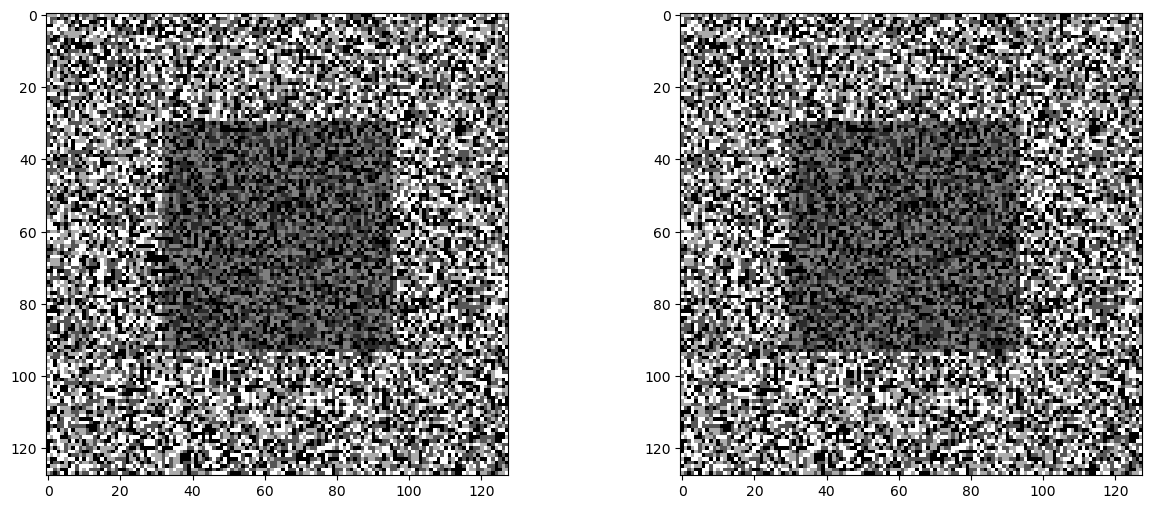

In [197]:
L = cv2.imread(os.path.join(path, 'pair0-L.png'), 0) / 255
R = cv2.imread(os.path.join(path, 'pair0-R.png'), 0) / 255

plt.figure(figsize=(15, 6))
plt.subplot(121)
plt.imshow(L)
plt.subplot(122)
plt.imshow(R)
plt.show()

## Part A

Implement the SSD match algorithm as function disparity_ssd(L, R) that returns a disparity image D(y,x) such that L(y,x) = R(y,x+D(y,x)) when matching from left (L) to right (R).

You will implement this function in numerous versions, pixel-wise, vectorized and with shared computations.

Consider what parameters you'd like your function to have, consider runtime and assumptions you can make of the output.

### Pixel wise

In [ ]:
from tqdm import tqdm


def disparity_ssd_pixel_wise(L: np.ndarray, R: np.ndarray, window_size: int, max_offset: int):
    """Compute disparity map D(y, x) such that: L(y, x) = R(y, x + D(y, x))

    This function computes disparity separately for each pixel

    Params:
    L: Grayscale left image
    R: Grayscale right image, same size as L
    window_size: Size of the window to use for SSD computation
    max_offset: Maximum disparity to search for

    Returns: Disparity map, same size as L, R
    """
    D = np.zeros_like(L)
    w = (window_size - 1) // 2  # effective window size
    max_offset = min(max_offset, L.shape[1] - 1)
    num_rows, num_cols = L.shape

    L_padded = np.pad(L, w, mode='constant', constant_values=0)
    R_padded = np.pad(R, w, mode='constant', constant_values=0)

    for row in tqdm(range(num_rows)):
        for col in range(num_cols):
            patch = L_padded[row:row + window_size, col:col + window_size]
            disparity = 0
            min_ssd = np.inf
            for d in range(-max_offset, max_offset + 1):
                if col + d < 0 or col + d + 1 > num_cols:
                    continue  # skip out of bounds shifts
                window = R_padded[row:row + window_size, col + d:col + d + window_size] # sliding window view
                ssd = np.sum((patch - window) ** 2)
                if ssd < min_ssd:
                    min_ssd = ssd
                    disparity = d
            D[row, col] = disparity
    return D


D_L = disparity_ssd_pixel_wise(L, R, window_size=15, max_offset=16)
D_R = disparity_ssd_pixel_wise(R, L, window_size=15, max_offset=16)

plt.figure(figsize=(15, 6))
plt.subplot(121)
plt.imshow(D_L)
plt.colorbar()
plt.subplot(122)
plt.imshow(D_R)
plt.colorbar()
plt.show()

This looks pretty much perfect.

### Vectorized

How would you like to vectorize the functions? Try out a few variations.

Consider the parameters of your function as well as memory constraints.

You may ask your mentor for help.

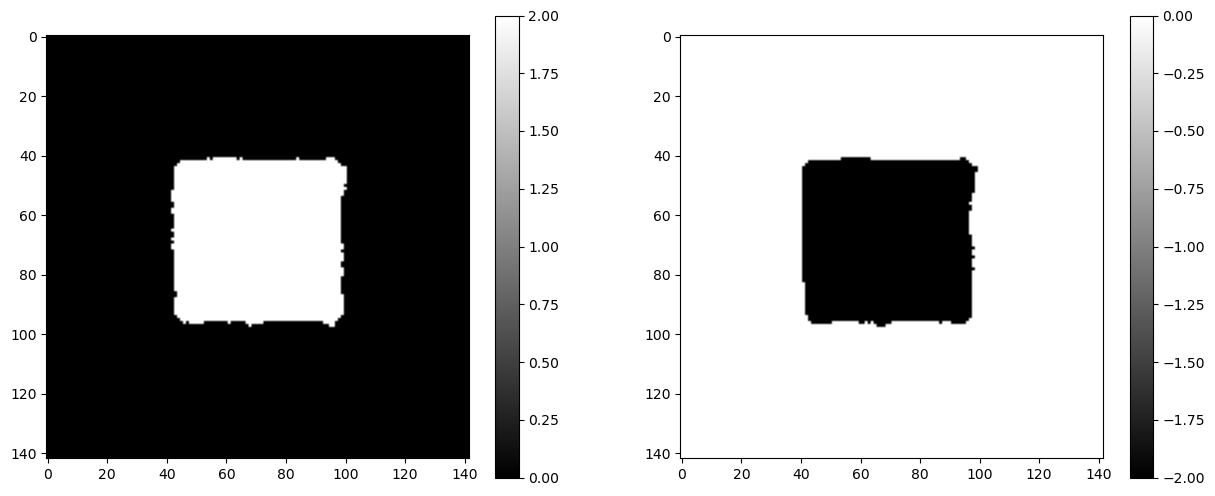

In [205]:
from scipy.ndimage import convolve
from scipy.signal import convolve2d


def disparity_ssd_vectorized(L: np.ndarray, R: np.ndarray, window_size: int, max_offset: int):
    """Compute disparity map D(y, x) such that: L(y, x) = R(y, x + D(y, x))

    This function computes disparity ...

    Params:
    L: Grayscale left image
    R: Grayscale right image, same size as L
    window_size: Size of the window to use for SSD computation
    max_offset: Maximum disparity to search for

    Returns: Disparity map, same size as L, R
    """
    w = (window_size - 1) // 2  # effective window size
    max_offset = min(max_offset, L.shape[1] - 1)

    L_padded = np.pad(L, w, mode='constant', constant_values=0)
    R_padded = np.pad(R, w, mode='constant', constant_values=0)

    R_shifted = np.stack([np.roll(R_padded, shift, axis=1) for shift in range(-max_offset, max_offset + 1)], axis=0)
    diffs = (L_padded - R_shifted) ** 2

    # window_diffs = np.array([convolve2d(d, np.ones((window_size, window_size)), mode='same') for d in diffs])
    footprint = np.ones((window_size, window_size))
    window_diffs = convolve(diffs, footprint[None, :, :], mode='constant', cval=0)  # about twice as fast
    D = np.argmin(window_diffs, axis=0) - max_offset
    
    return D


D_L = disparity_ssd_vectorized(L, R, window_size=15, max_offset=16)
D_R = disparity_ssd_vectorized(R, L, window_size=15, max_offset=16)

plt.figure(figsize=(15, 6))
plt.subplot(121)
plt.imshow(D_L)
plt.colorbar()
plt.subplot(122)
plt.imshow(D_R)
plt.colorbar()
plt.show()

In [206]:
start = time.time()
D_L = disparity_ssd_vectorized(L, R, window_size=19, max_offset=125)
D_R = disparity_ssd_vectorized(R, L, window_size=19, max_offset=125)
print('Total runtime for function {} is {:.2f}s'.format(disparity_ssd_vectorized.__name__, time.time() - start))

Total runtime for function disparity_ssd_vectorized is 6.40s


# Part 2 A

Again apply your SSD match function, and create a disparity image D(y,x) such that L(y,x) = R(y,x+D(y,x)) when matching from left to right. Also match from right to left.

Try out the different versions you implemented and compare their runtimes and results. The results should all be the same.

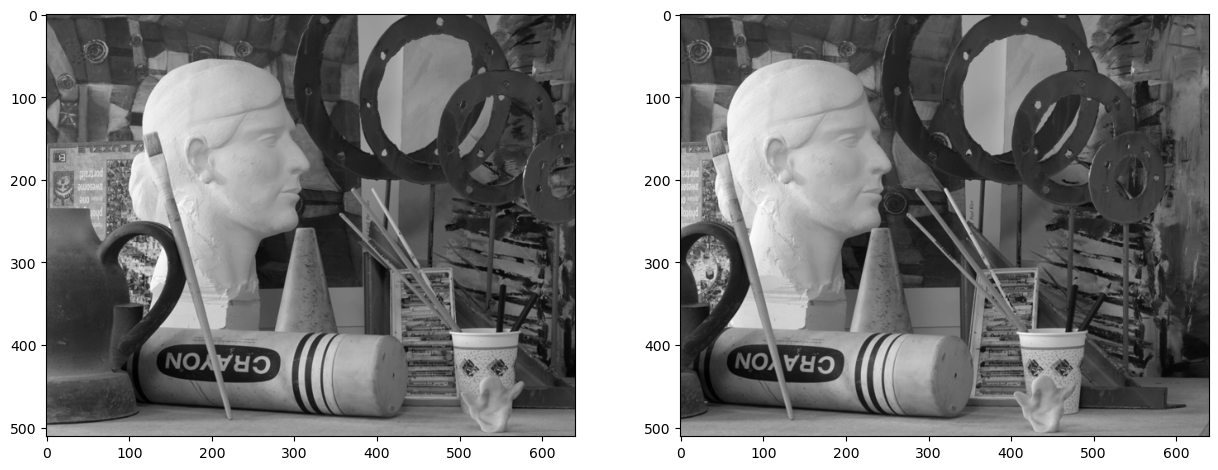

In [211]:
L = cv2.imread(os.path.join(path, 'pair1-L.png'), 0) / 255
R = cv2.imread(os.path.join(path, 'pair1-R.png'), 0) / 255

plt.figure(figsize=(15, 6))
plt.subplot(121)
plt.imshow(L)
plt.subplot(122)
plt.imshow(R)
plt.show()

100%|██████████| 511/511 [12:17<00:00,  1.44s/it]


Total runtime for function disparity_ssd_pixel_wise is 1491.19s


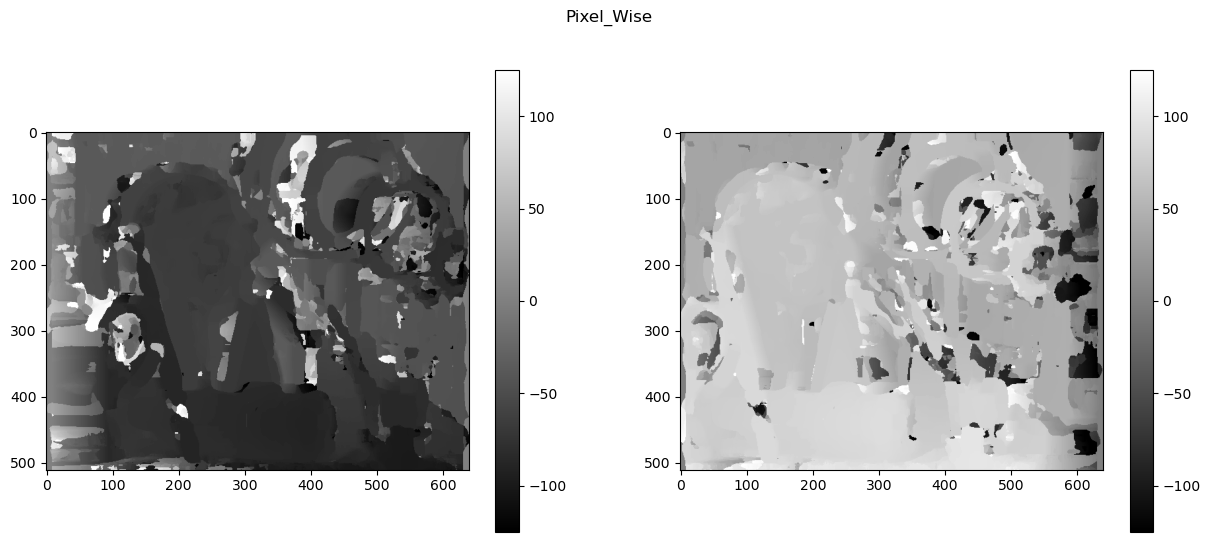

Total runtime for function disparity_ssd_vectorized is 156.49s


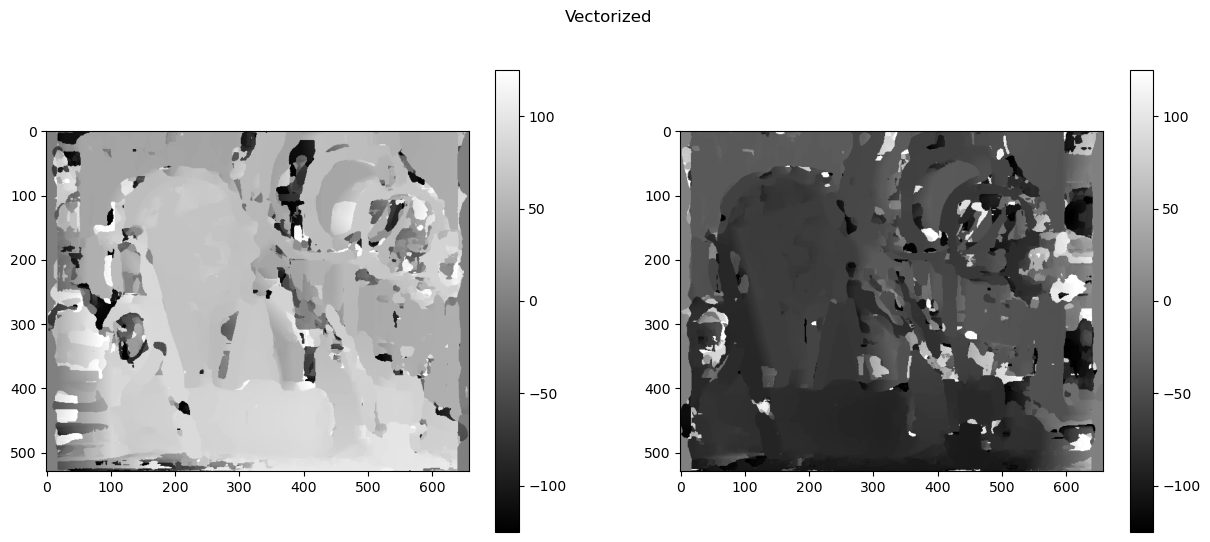

In [127]:
for disparity_func in [
    disparity_ssd_pixel_wise,
    disparity_ssd_vectorized
]:
    start = time.time()
    D_L = disparity_func(L, R, window_size=19, max_offset=125)
    D_R = disparity_func(R, L, window_size=19, max_offset=125)
    print('Total runtime for function {} is {:.2f}s'.format(disparity_func.__name__, time.time() - start))

    plt.figure(figsize=(15, 6))
    plt.suptitle(disparity_func.__name__.replace('disparity_ssd_', '').title())
    plt.subplot(121)
    plt.imshow(D_L)
    plt.colorbar()
    plt.subplot(122)
    plt.imshow(D_R)
    plt.colorbar()
    plt.show()

Surprisingly, pixel wise is much faster than columns wise. 

Unsurprisingly, the shared version is the fastest and produces almost identical results, so we'll use it from now on.

# Part 2 b

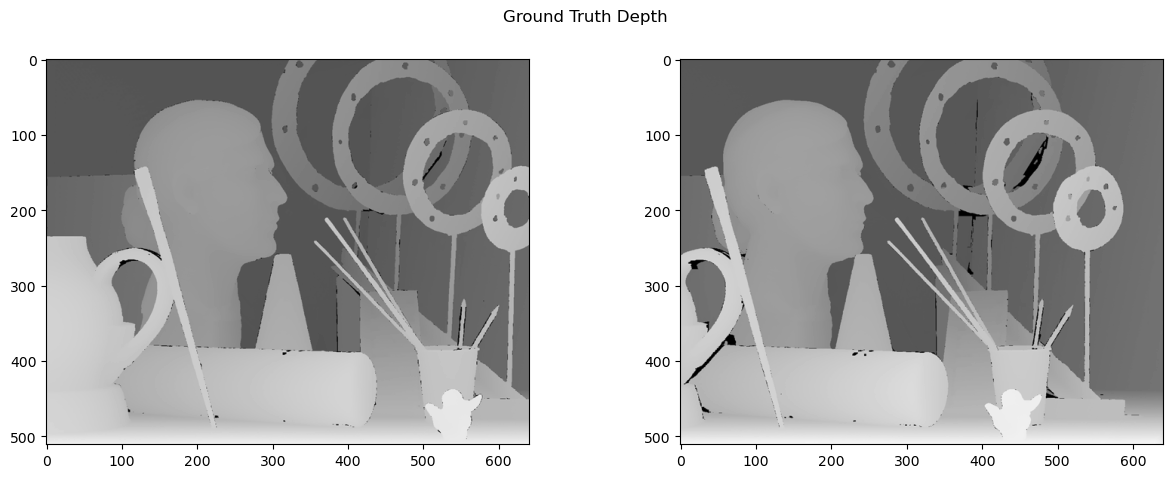

In [129]:
gt_D_L = cv2.imread(os.path.join(path, 'pair1-D_L.png'), 0) / 255
gt_D_R = cv2.imread(os.path.join(path, 'pair1-D_R.png'), 0) / 255

plt.figure(figsize=(15, 5))
plt.suptitle('Ground Truth Depth')
plt.subplot(121)
plt.imshow(gt_D_L)
plt.subplot(122)
plt.imshow(gt_D_R)
plt.show()

This is obviously much clearer than the depth our function gets, but a lot of the underlying structure is seen in both pictures.

# Part 3 a

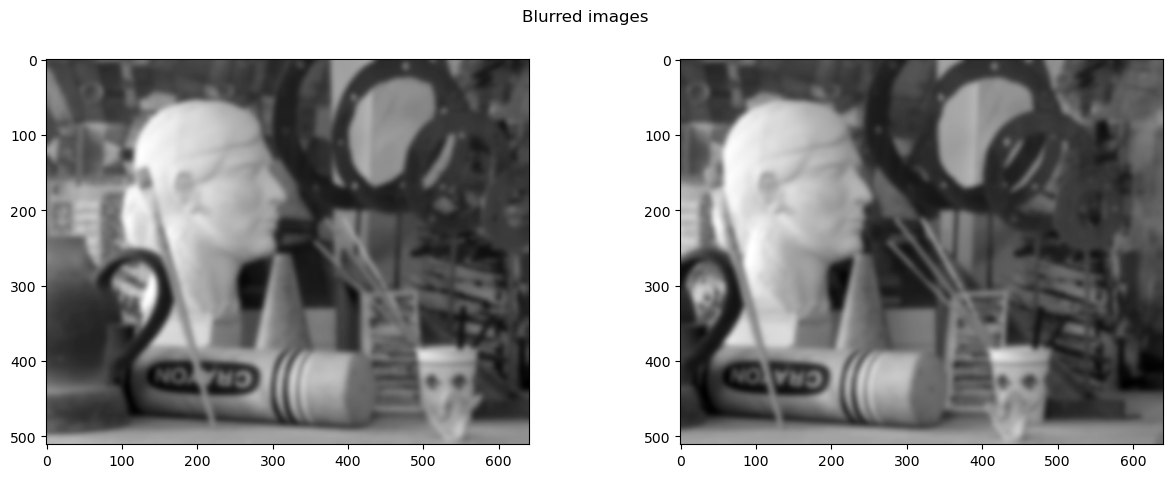

In [137]:
L_blur = cv2.GaussianBlur(L, (21, 21), 0)
R_blur = cv2.GaussianBlur(R, (21, 21), 0)

plt.figure(figsize=(15, 5))
plt.suptitle('Blurred images')
plt.subplot(121)
plt.imshow(L_blur)
plt.subplot(122)
plt.imshow(R_blur)
plt.show()

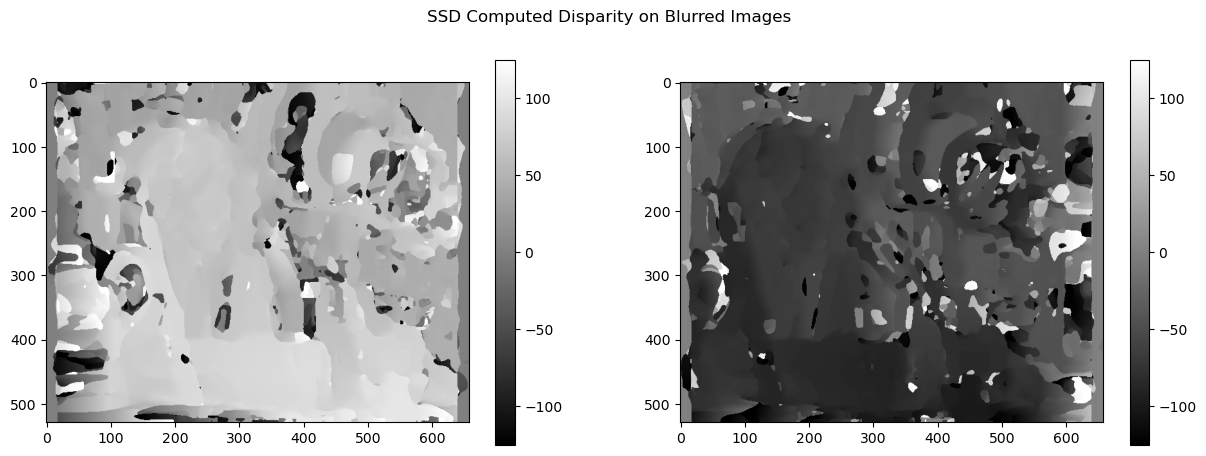

In [139]:
D_L_blur = disparity_ssd_vectorized(L_blur, R_blur, window_size=19, max_offset=125)
D_R_blur = disparity_ssd_vectorized(R_blur, L_blur, window_size=19, max_offset=125)

plt.figure(figsize=(15, 5))
plt.suptitle('SSD Computed Disparity on Blurred Images')
plt.subplot(121)
plt.imshow(D_L_blur)
plt.colorbar()
plt.subplot(122)
plt.imshow(D_R_blur)
plt.colorbar()
plt.show()

How does this look?
looks worse

# Part 3 b

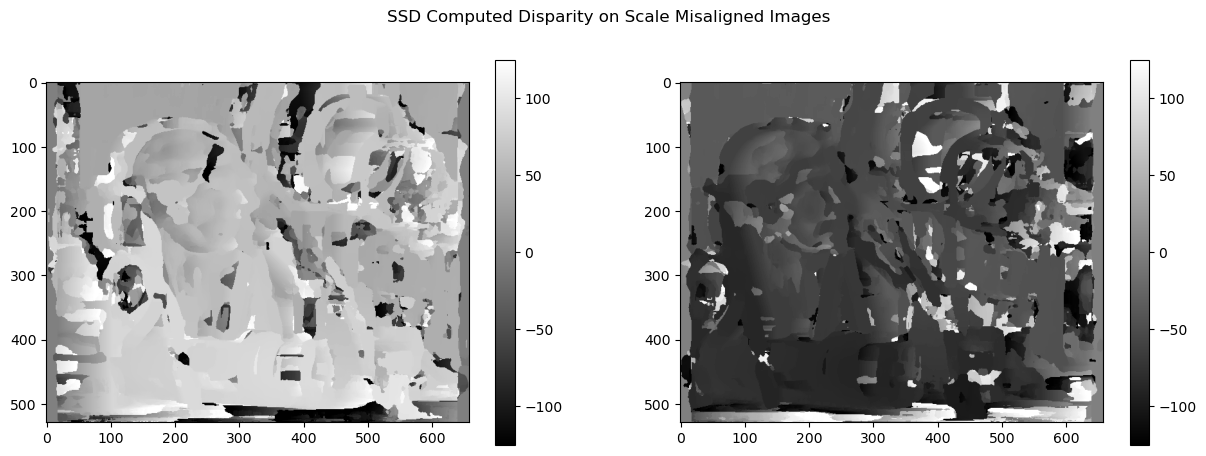

In [140]:
R_contrast = R * 1.1

D_L_cont = disparity_ssd_vectorized(L, R_contrast, window_size=19, max_offset=125)
D_R_cont = disparity_ssd_vectorized(R_contrast, L, window_size=19, max_offset=125)

plt.figure(figsize=(15, 5))
plt.suptitle('SSD Computed Disparity on Scale Misaligned Images')
plt.subplot(121)
plt.imshow(D_L_cont)
plt.colorbar()
plt.subplot(122)
plt.imshow(D_R_cont)
plt.colorbar()
plt.show()

imsave(D_L_blur, 'output/ps2-3-b-1.png')
imsave(D_R_blur, 'output/ps2-3-b-2.png')

What about now?
better

# Part 4 a

Implement a window matching stereo algorithm using some form of normalized correlation. Again, write this as a function disparity_ncorr(L, R) that returns a disparity image D(y,x) such that L(y,x) = R(y,x+D(y,x)) when matching from left (L) to right (R). 

Use OpenCV's funtion matchTemplate with flag TM_CCOEFF_NORMED. Take a look at some of the other flags they have available.

*Question*: What is the most efficient possible implementation of this new disparity function? Pixel-wise/column-wise/shared compuatation?

In [286]:
def disparity_ncorr_vectorized(L: np.ndarray, R: np.ndarray, window_size: int, max_offset: int):
    """
    Computes disparity map using normalized correlation.

    Args:
        L: Left image.
        R: Right image.
        window_size: Size of the matching window.
        max_offset: Maximum search range for disparity.

    Returns:
        Disparity image.
    """
    w = (window_size - 1) // 2  # effective window size
    max_offset = min(max_offset, L.shape[1] - 1)

    L_padded = np.pad(L, w, mode='constant', constant_values=0)
    R_padded = np.pad(R, w, mode='constant', constant_values=0)

    R_shifted = np.stack([np.roll(R_padded, shift, axis=1) for shift in range(-max_offset, max_offset + 1)], axis=0)
    mult = R_shifted * L_padded
    convolved_mult = convolve(mult, np.ones((1, window_size, window_size)), mode='constant', cval=0.0)  # dot products

    denominator_L = np.sqrt(convolve2d(L_padded ** 2, np.ones((window_size, window_size)), mode='same'))
    denominator_R = np.sqrt(convolve2d(R_padded ** 2, np.ones((window_size, window_size)), mode='same'))
    rolled_denominator_R = np.stack([np.roll(denominator_R, shift, axis=1) for shift in range(-max_offset, max_offset + 1)], axis=0)
    
    normalized_scores = convolved_mult / (denominator_L * rolled_denominator_R)
    D = np.argmax(normalized_scores, axis=0) - max_offset

    return D

In [315]:
def disparity_ncorr_pixel_wise(L: np.ndarray, R: np.ndarray, window_size: int, max_offset: int):
    """Compute disparity map D(y, x) such that: L(y, x) = R(y, x + D(y, x))

    This function computes disparity separately for each pixel

    Params:
    L: Grayscale left image
    R: Grayscale right image, same size as L
    window_size: Size of the window to use for SSD computation
    max_offset: Maximum disparity to search for

    Returns: Disparity map, same size as L, R
    """
    D = np.zeros_like(L)
    w = (window_size - 1) // 2  # effective window size
    max_offset = min(max_offset, L.shape[1] - 1)
    num_rows, num_cols = L.shape

    L_padded = np.pad(L, w, mode='constant', constant_values=0).astype(np.float32)
    R_padded = np.pad(R, w, mode='constant', constant_values=0).astype(np.float32)

    for row in tqdm(range(num_rows)):
        for col in range(num_cols):
            patch = L_padded[row:row + window_size, col:col + window_size]
            disparity = 0
            max_corr = -np.inf
            for d in range(-max_offset, max_offset + 1):
                if col + d < 0 or col + d + 1 > num_cols:
                    continue  # skip out of bounds shifts
                window = R_padded[row:row + window_size, col + d:col + d + window_size] # sliding window view
                corr = cv2.matchTemplate(patch, window, cv2.TM_CCOEFF_NORMED) 
                if corr > max_corr :
                    max_corr = corr
                    disparity = d
            D[row, col] = disparity
    return D

In [236]:
# old 
L = cv2.imread(os.path.join(path, 'pair0-L.png'), 0) / 255
R = cv2.imread(os.path.join(path, 'pair0-R.png'), 0) / 255

In [288]:
D_L = disparity_ncorr_vectorized(L, R, window_size=15, max_offset=25)
D_R = disparity_ncorr_vectorized(R, L, window_size=15, max_offset=25)

In [290]:
#new
L = cv2.imread(os.path.join(path, 'pair1-L.png'), 0) / 255
R = cv2.imread(os.path.join(path, 'pair1-R.png'), 0) / 255

In [291]:
D_L = disparity_ncorr_vectorized(L, R, window_size=19, max_offset=125)
D_R = disparity_ncorr_vectorized(R, L, window_size=19, max_offset=125)

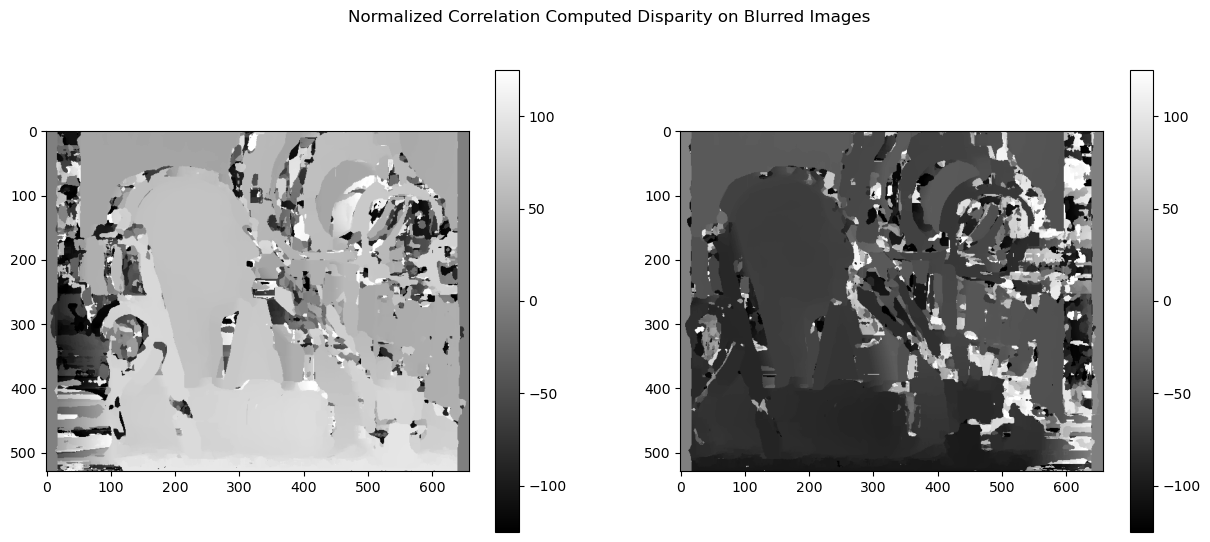

In [292]:
plt.figure(figsize=(15, 6))
plt.suptitle('Normalized Correlation Computed Disparity on Blurred Images')
plt.subplot(121)
plt.imshow(D_L)
plt.colorbar()
plt.subplot(122)
plt.imshow(D_R)
plt.colorbar()
plt.show()

imsave(D_L_cont, 'output/ps2-4-a-1.png')
imsave(D_R_cont, 'output/ps2-4-a-2.png')

100%|██████████| 511/511 [24:34<00:00,  2.89s/it]


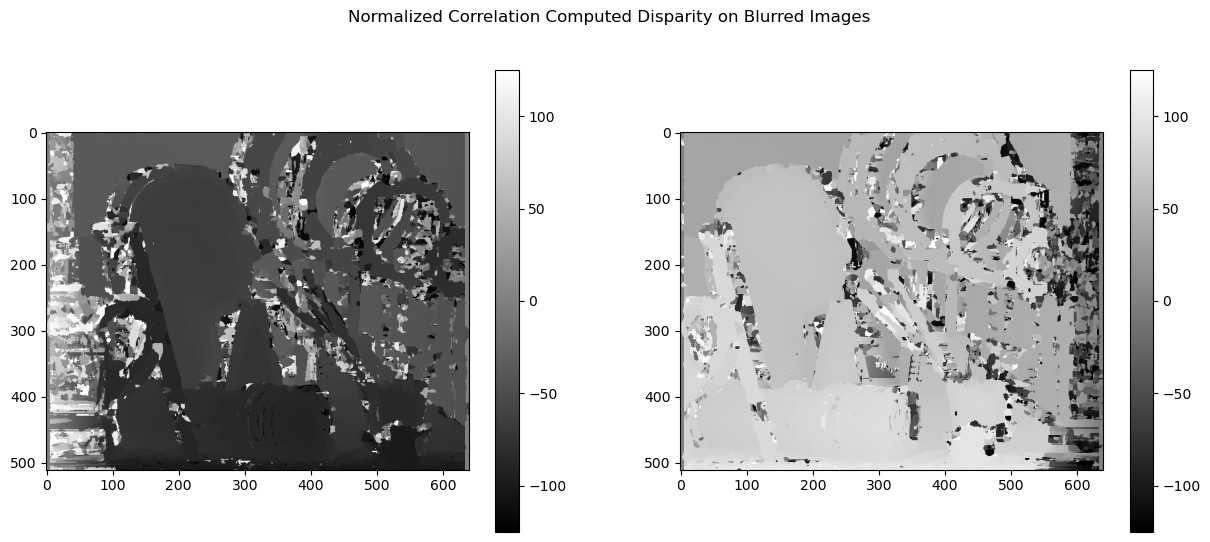

In [317]:
L = cv2.imread(os.path.join(path, 'pair1-L.png'), 0) / 255
R = cv2.imread(os.path.join(path, 'pair1-R.png'), 0) / 255
D_L = disparity_ncorr_pixel_wise(L, R, window_size=13, max_offset=125)
D_R = disparity_ncorr_pixel_wise(R, L, window_size=13, max_offset=125)


plt.figure(figsize=(15, 6))
plt.suptitle('Normalized Correlation Computed Disparity on Blurred Images')
plt.subplot(121)
plt.imshow(D_L)
plt.colorbar()
plt.subplot(122)
plt.imshow(D_R)
plt.colorbar()
plt.show()

imsave(D_L_cont, 'output/ps2-4-a-1.png')
imsave(D_R_cont, 'output/ps2-4-a-2.png')

How is the runtime? How do the results look?

looks good, run time a bit better 

# Part 4 b

### Now test it on both the noisy and contrast-boosted versions from 2-a and 2-b.

This new function should be more robust to pertubations, since it normalizes each patch by itself.

Let's try it on the blurred version:

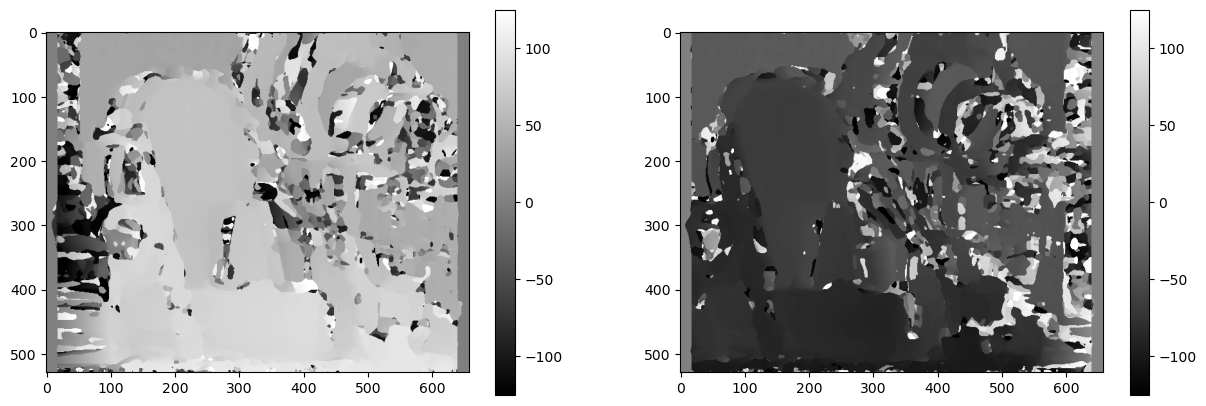

In [293]:
D_L_blur_ncorr = disparity_ncorr_vectorized(L_blur, R_blur, window_size=19, max_offset=125)
D_R_blur_ncorr = disparity_ncorr_vectorized(R_blur, L_blur, window_size=19, max_offset=125)

plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.imshow(D_L_blur_ncorr)
plt.colorbar()
plt.subplot(122)
plt.imshow(D_R_blur_ncorr)
plt.colorbar()
plt.show()

How does this look?

Now the contrast boosted version:

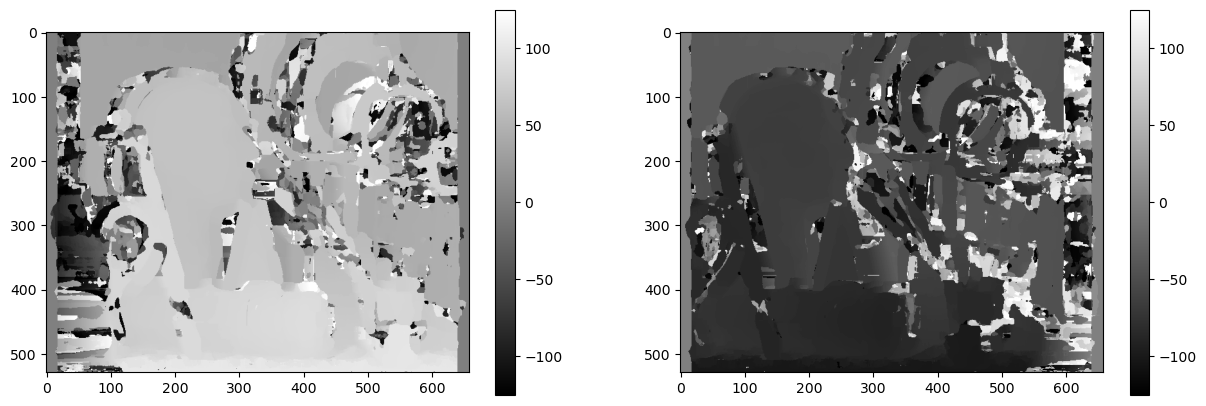

In [294]:
R_contrast = R * 1.1

D_L_cont_ncorr = disparity_ncorr_vectorized(L, R_contrast, window_size=19, max_offset=125)
D_R_cont_ncorr = disparity_ncorr_vectorized(R_contrast, L, window_size=19, max_offset=125)

plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.imshow(D_L_cont_ncorr)
plt.colorbar()
plt.subplot(122)
plt.imshow(D_R_cont_ncorr)
plt.colorbar()
plt.show()

What about this?

good

# Part 5 

Try your algorithms on this pair. Play with the images – smooth, sharpen, etc. Keep comparing to the ground truth (pair2-D_L.png and pair2-D_R.png).

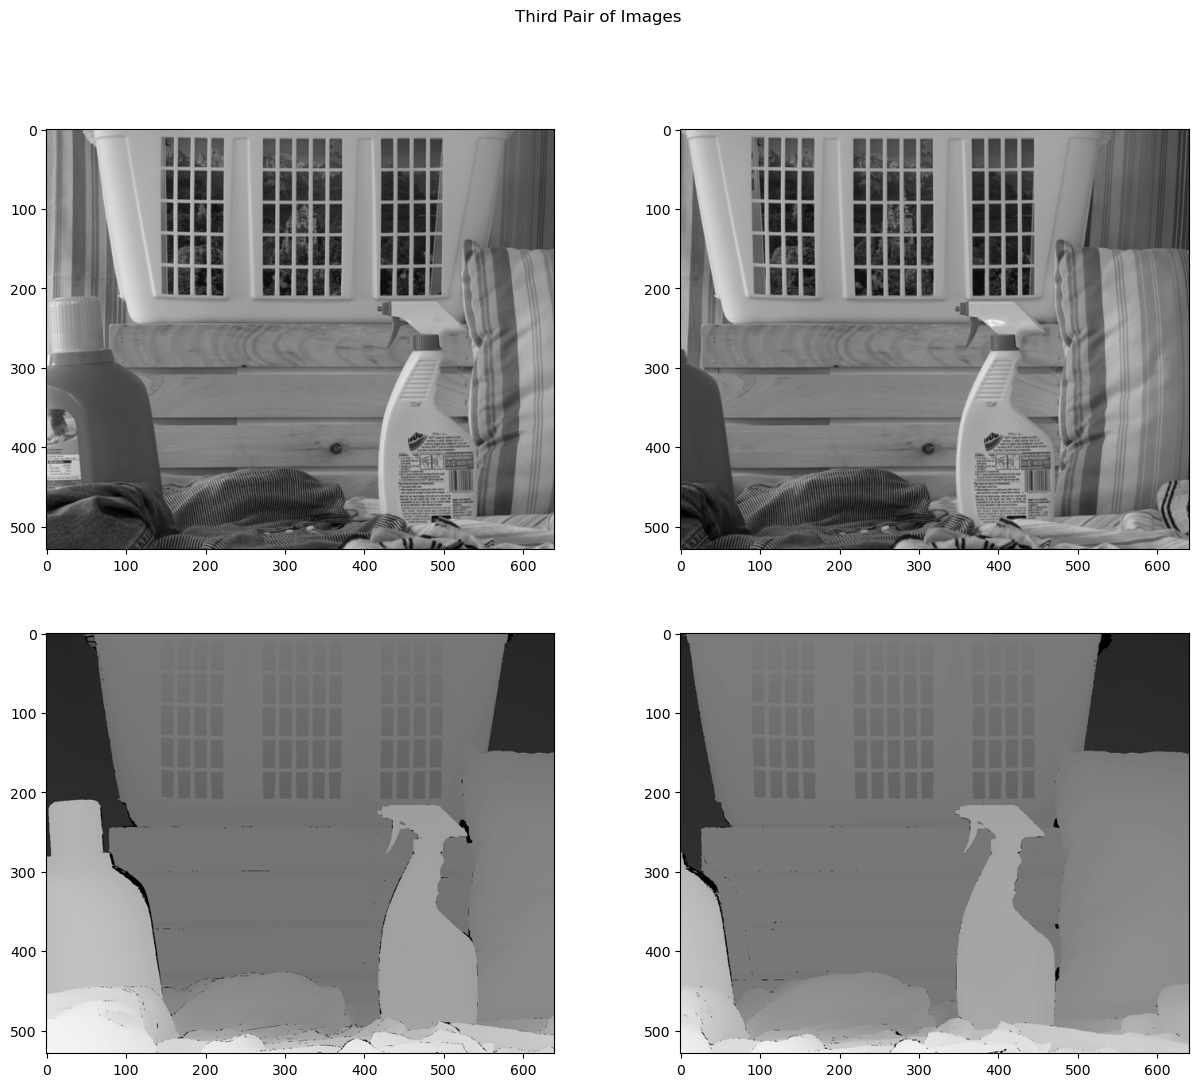

In [296]:
L = cv2.imread(os.path.join(path, 'pair2-L.png'), 0) / 255
R = cv2.imread(os.path.join(path, 'pair2-R.png'), 0) / 255
gt_D_L = cv2.imread(os.path.join(path, 'pair2-D_L.png'), 0)
gt_D_R = cv2.imread(os.path.join(path, 'pair2-D_R.png'), 0)

plt.figure(figsize=(15, 12))
plt.suptitle('Third Pair of Images')
plt.subplot(221)
plt.imshow(L)
plt.subplot(222)
plt.imshow(R)
plt.subplot(223)
plt.imshow(gt_D_L)
plt.subplot(224)
plt.imshow(gt_D_R)
plt.show()

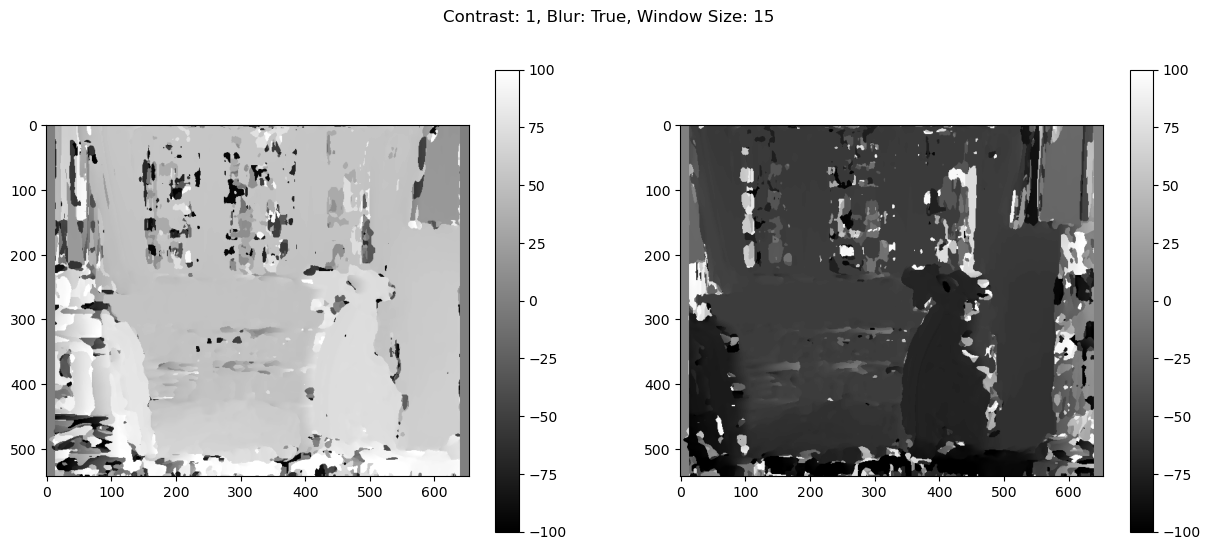

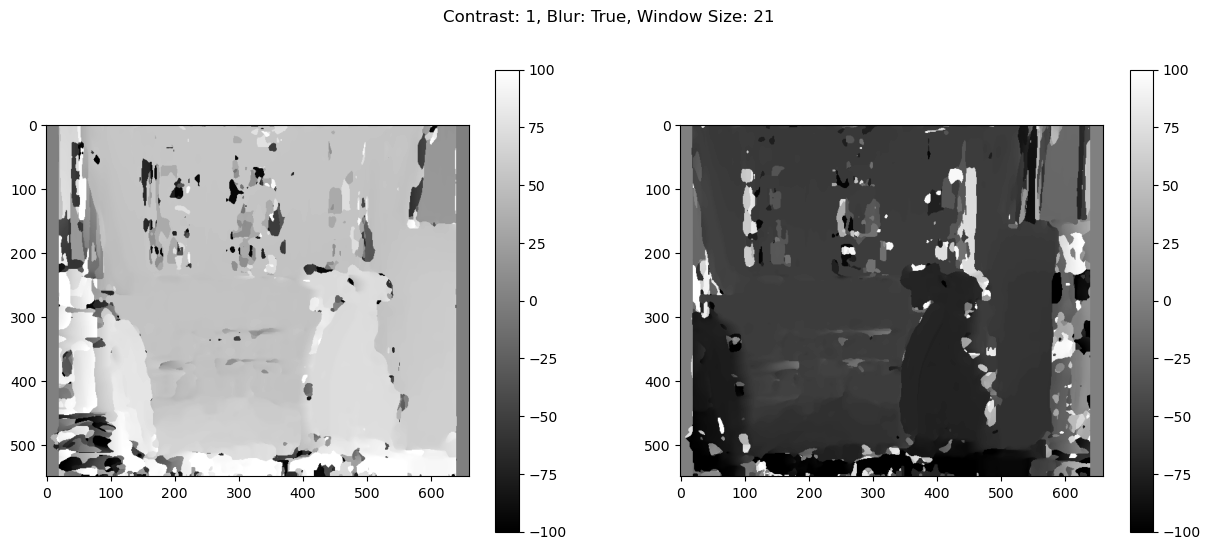

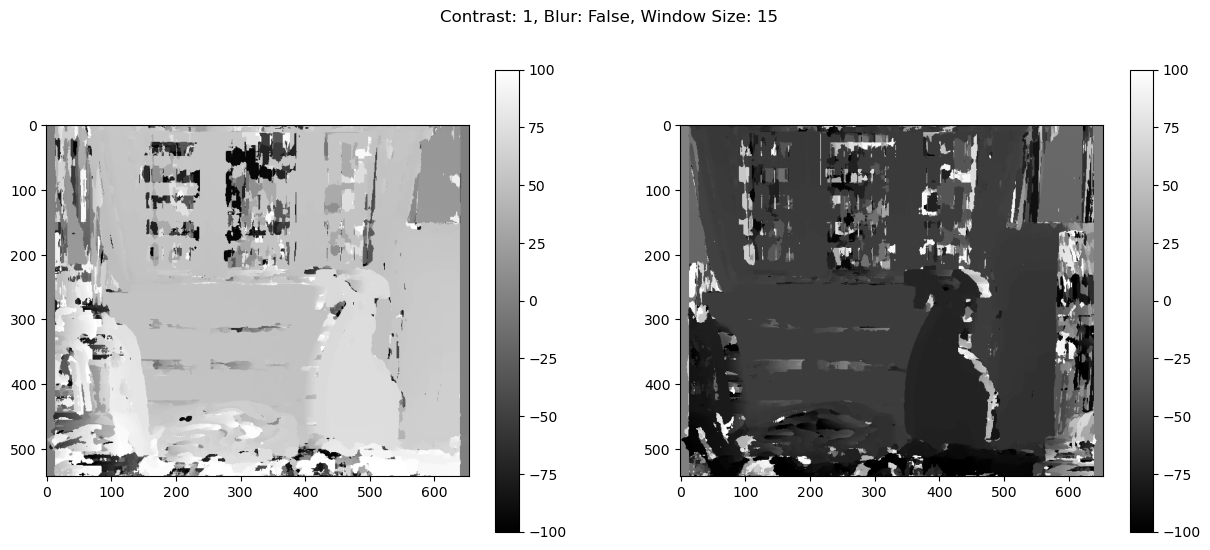

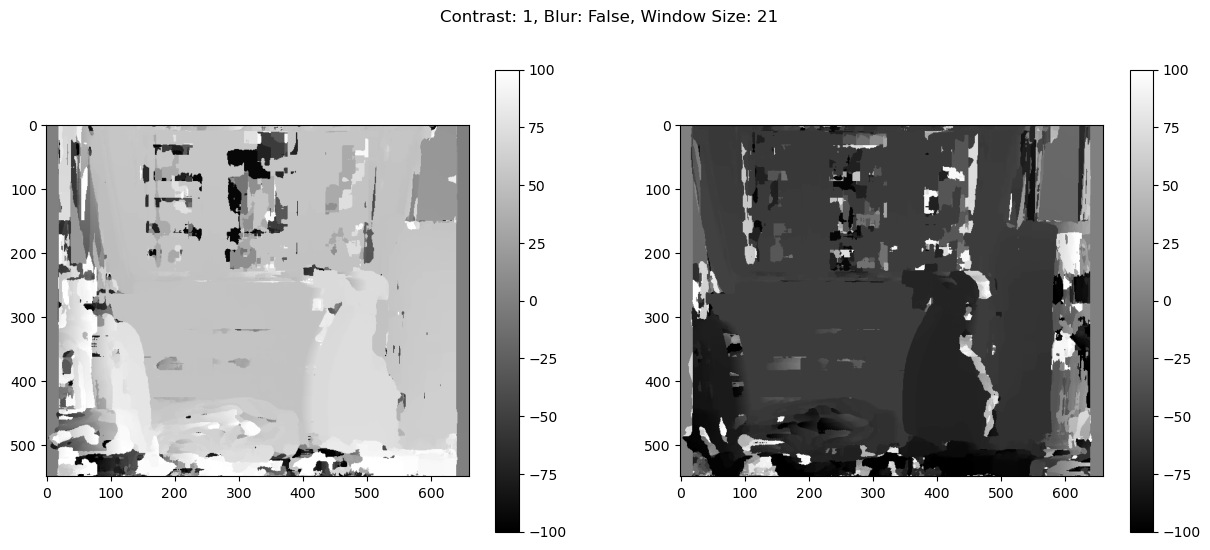

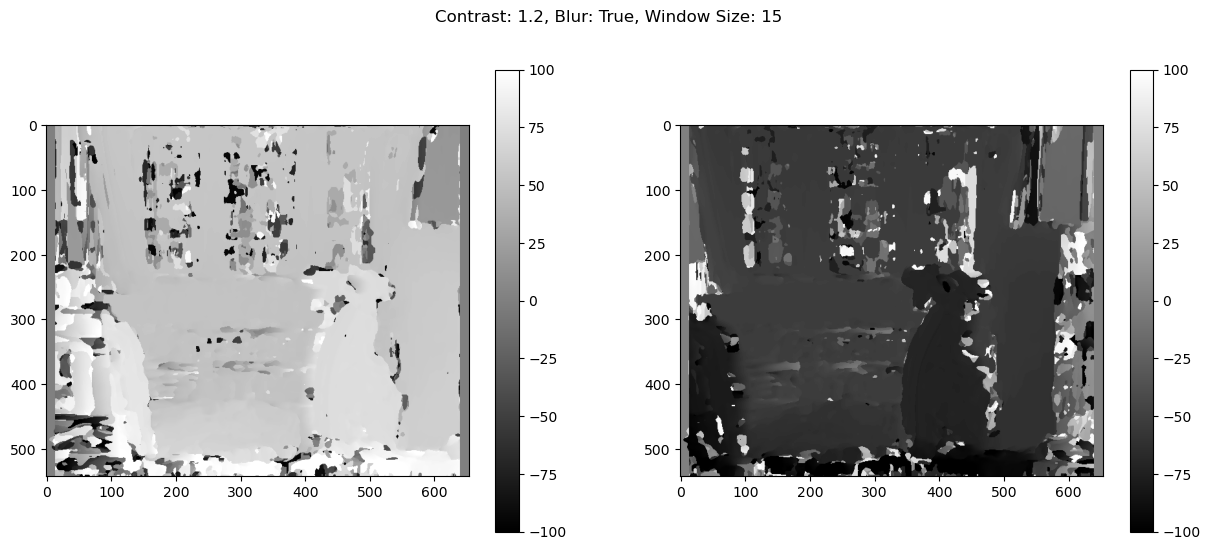

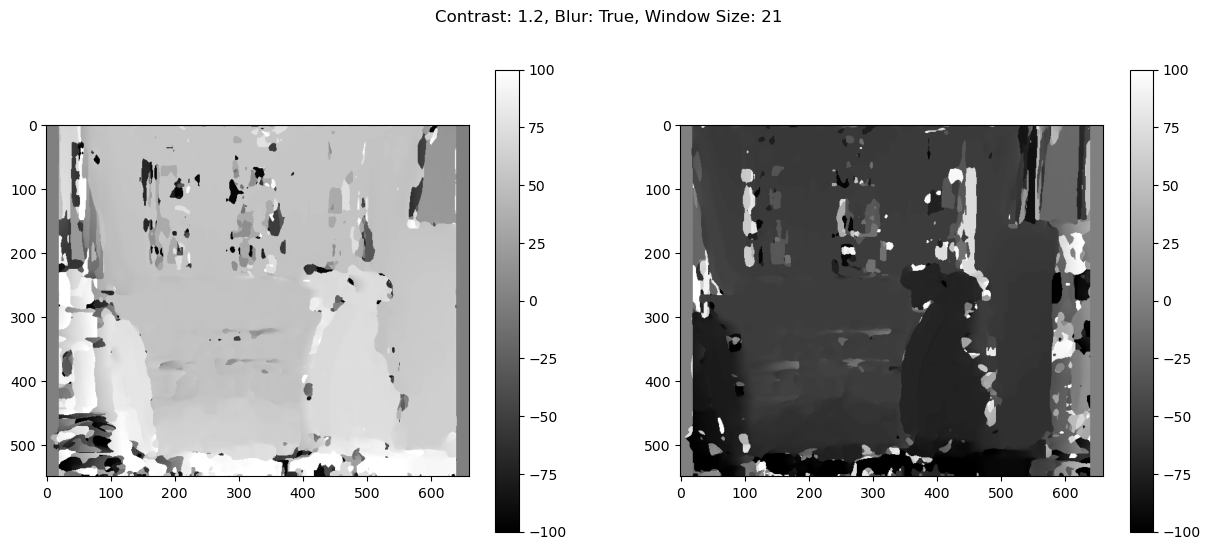

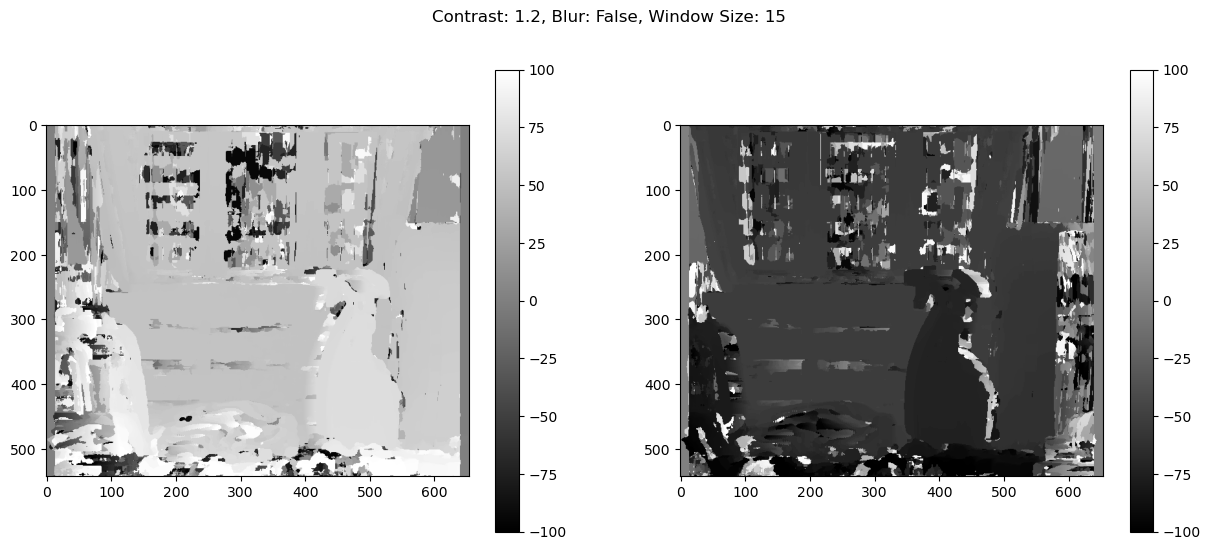

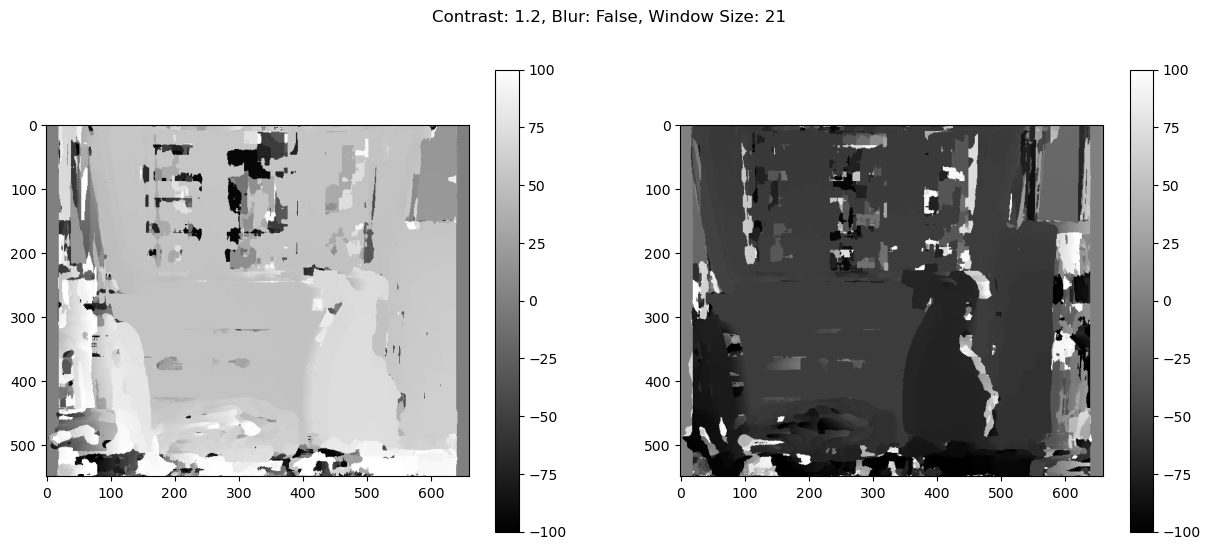

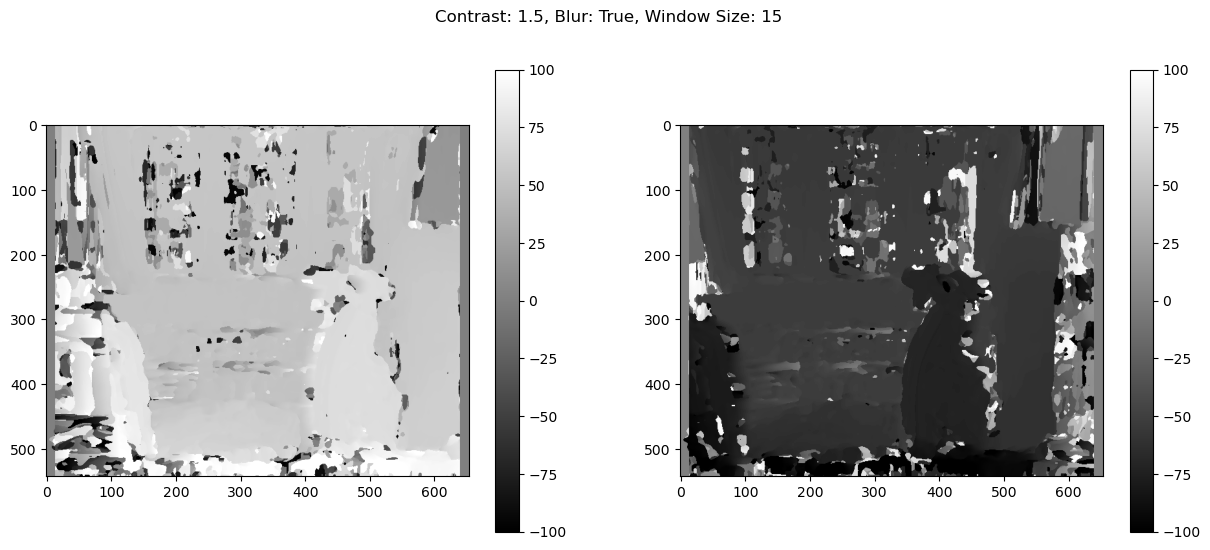

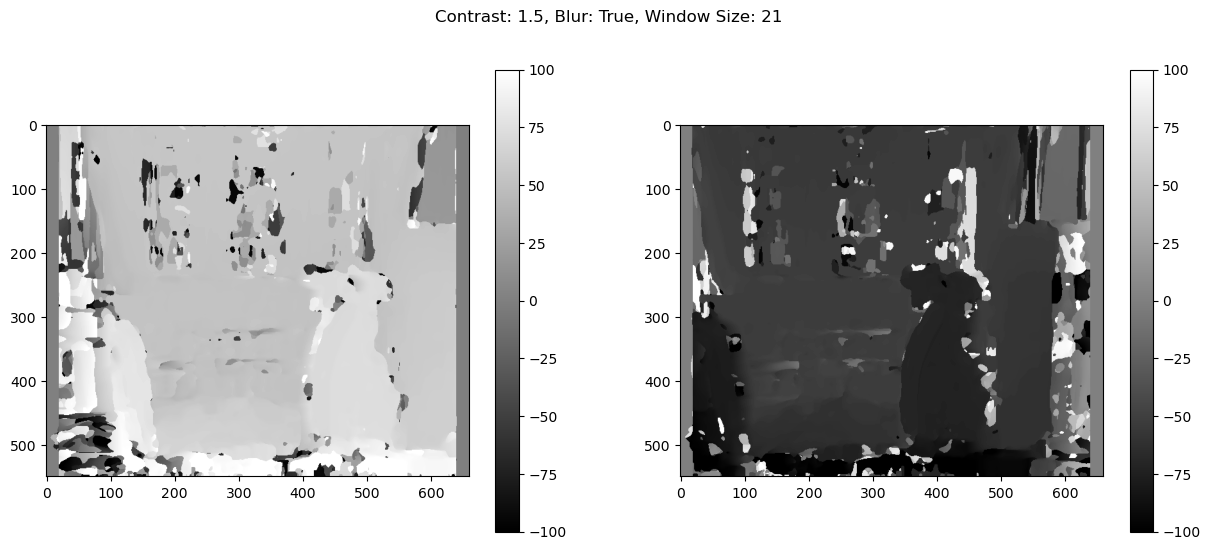

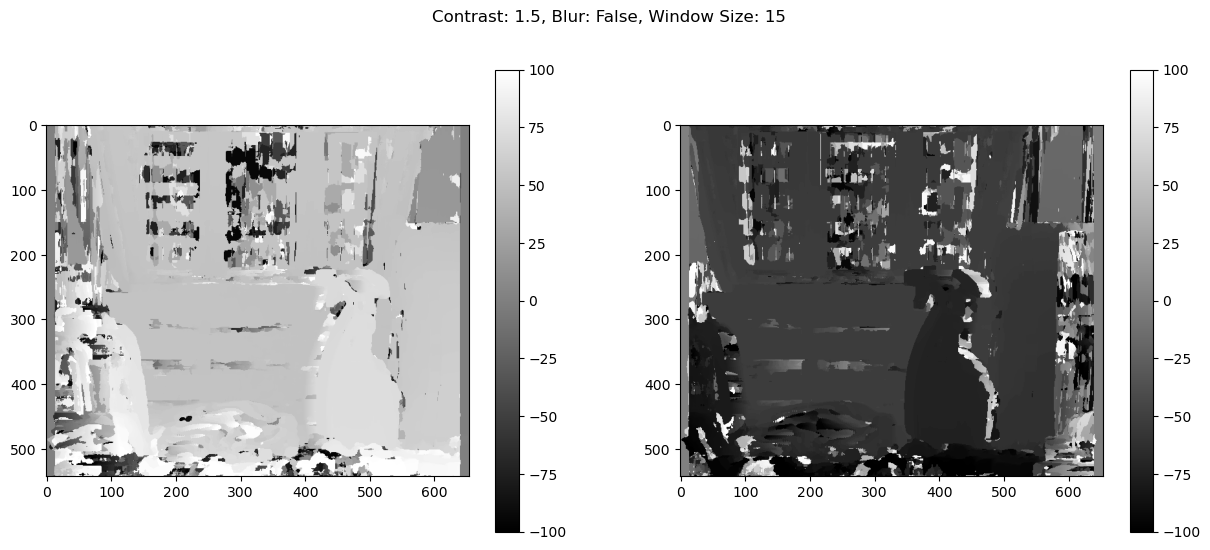

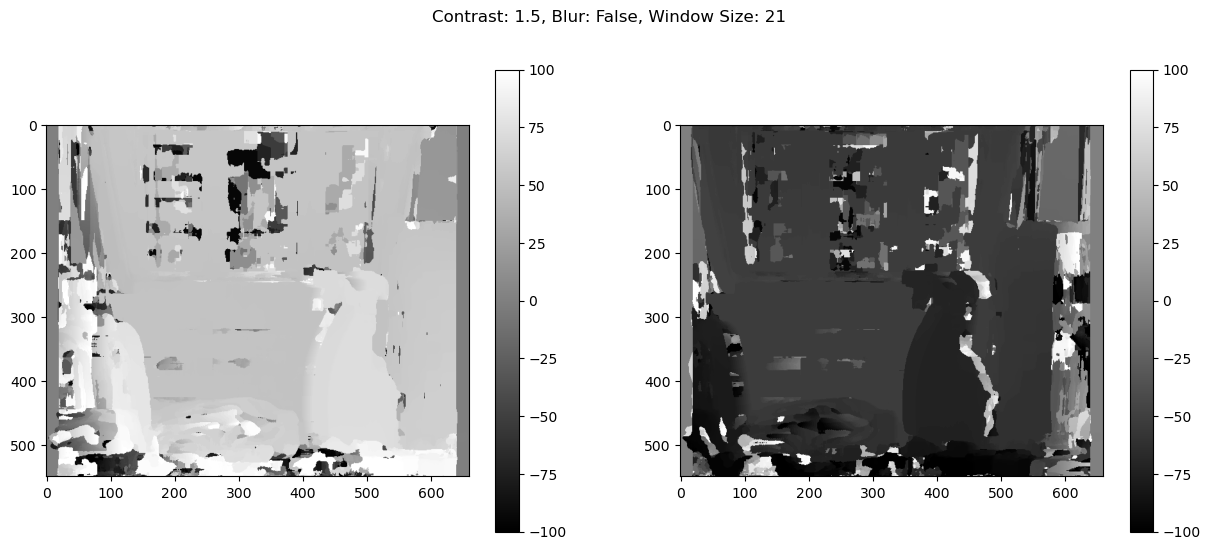

In [299]:
contrasts = [1, 1.2, 1.5]
blur = [True, False]
window_sizes = [15, 21]

for contrast in contrasts:
    for blur_flag in blur:
        for window_size in window_sizes:
            R_contrast = R * contrast
            if blur_flag:
                L_blur = cv2.GaussianBlur(L, (21, 21), 0)
                R_blur = cv2.GaussianBlur(R_contrast, (21, 21), 0)
                D_L = disparity_ncorr_vectorized(L_blur, R_blur, window_size=window_size, max_offset=100)
                D_R = disparity_ncorr_vectorized(R_blur, L_blur, window_size=window_size, max_offset=100)
            else:
                D_L = disparity_ncorr_vectorized(L, R_contrast, window_size=window_size, max_offset=100)
                D_R = disparity_ncorr_vectorized(R_contrast, L, window_size=window_size, max_offset=100)

            plt.figure(figsize=(15, 6))
            plt.suptitle('Contrast: {}, Blur: {}, Window Size: {}'.format(contrast, blur_flag, window_size))
            plt.subplot(121)
            plt.imshow(D_L)
            plt.colorbar()
            plt.subplot(122)
            plt.imshow(D_R)
            plt.colorbar()
            plt.show()

How does this look? What hyperparmeter issues did you face?

*Question:* Can you automate this process? If so, how?

Yes, we can check the distance of the gt image and our computed disparity image. (In norm or mse etc.)
Another way, is to check the signal to noise ratio (SNR) of our images, as the gt image are perfect, the higher the SNR, the better our image is.